# Lets transform the trained model into ONNX format

## Run this to convert

In [1]:
%pip install -U tf2onnx
!python -m tf2onnx.convert --saved-model ./saved/tf_model/ --output ./onnx/f-crnn.onnx

Note: you may need to restart the kernel to use updated packages.
/home/mus5900/anaconda3/envs/series_forcasting/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-04-06 01:06:09,430 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-04-06 01:06:12,283 - INFO - Signatures found in model: [serving_default].
2022-04-06 01:06:12,283 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-04-06 01:06:12,284 - INFO - Output names: ['output_0']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-04-06 01:06:12,758 - WARNING - From /home/mus5900/anaconda3/envs/series_forcasting/lib/python3.9/site-packages/tf2onnx/tf_loader.py:706: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be r

## Lets now test the converted model

In [1]:
import onnxruntime as ort
import numpy as np
from time import time

tf_random_tensor = np.random.rand(1, 201, 498)
tf_random_tensor = tf_random_tensor.astype(np.float32)

ort_sess = ort.InferenceSession('onnx/f-crnn.onnx')
outputs = ort_sess.run([], {'x': tf_random_tensor})
# Print Result
# result = outputs[0].argmax(axis=1)
print("Activations :", outputs[0][0])
# print("label :",result[0])

tik = time()
ort_sess.run([], {'x': tf_random_tensor})
tok = time()
print("Duration :{:.3f}s".format(tok-tik))

Activations : [-1.0927259  0.3824161]
Duration :0.002s


### Lets test real inputs now

In [2]:
!ls ../data/LibriCount |grep 5_fe1759

5_fe1759.json
5_fe1759.wav


In [3]:
!cat ../data/LibriCount/5_fe1759.json

[{"sex": "F", "activity": [[0, 32957], [33438, 53938], [56821, 58583], [58743, 80000]], "speaker_id": 2961}, {"sex": "F", "activity": [[0, 36160], [39363, 80000]], "speaker_id": 4970}, {"sex": "F", "activity": [[0, 10054], [14699, 29594], [30395, 32156], [32957, 34719], [35199, 56981], [57301, 80000]], "speaker_id": 4992}, {"sex": "M", "activity": [[0, 44489], [47852, 76360]], "speaker_id": 61}, {"sex": "M", "activity": [[0, 28152], [30395, 31836], [31996, 80000]], "speaker_id": 8230}]

In this audio, there is 2 M and 3 F

In [4]:
import scipy.signal
from scipy.io import wavfile
import librosa

FFT_N_PERSEG = 400
FFT_N_OVERLAP = 240
FFT_WINDOW_TYPE = "tukey"
# FFT_WINDOW_TYPE = "hann"
EPS = 1e-8

file = "../data/LibriCount/5_fe1759.wav"

# ---------------------------------------------------------------------------- #
#                          New model : gender counter                          #
# ---------------------------------------------------------------------------- #
sample_rate, clip = wavfile.read(file)
_, _, fft = scipy.signal.spectrogram(clip,
                                            fs = sample_rate,
                                            nperseg = FFT_N_PERSEG,
                                            noverlap = FFT_N_OVERLAP,
                                            window = FFT_WINDOW_TYPE
                                            )
fft = fft / (np.linalg.norm(fft, axis=0, keepdims=True) + EPS)
fft = fft.astype(np.float32)
fft = fft[None, :, :] # Add the batch dimension = 1
print("gender model input shape :", fft.shape)

# ---------------------------------------------------------------------------- #
#                                  Old models                                  #
# ---------------------------------------------------------------------------- #
clip_float =  clip / 33000
fft_old = np.abs(librosa.stft(clip_float, n_fft=400, hop_length=160)).T
fft_old = fft_old[:500, :]
fft_old = fft_old / (np.linalg.norm(fft_old, axis=0, keepdims=True) + EPS)
fft_old = fft_old.astype(np.float32)
fft_old = fft_old[None, :, :] # Add the batch dimension = 1
print("Counter model input shape :", fft_old.shape)

gender model input shape : (1, 201, 498)
Counter model input shape : (1, 500, 201)


In [5]:
ort_sess = ort.InferenceSession('onnx/f-crnn.onnx')

tik = time()
outputs = ort_sess.run([], {'x': fft})
tok = time()
print("Activations [M, F] :", outputs[0][0])
print("Duration :{:.3f}s".format(tok-tik))

Activations [M, F] : [3.2492657 2.6321983]
Duration :0.001s


If we round the activation values we get 3 Males and 3 Females, (Instead of 2 M and 3 F)

In [7]:
# ort_sess = ort.InferenceSession('onnx/f-crnn.onnx')
ort_sess = ort.InferenceSession('../old_model_conversion/onnx/CRNN_ONNX.onnx')

tik = time()
# outputs = ort_sess.run([], {'x': fft_rec})
outputs = ort_sess.run([], {'zero1_input': fft_old[None, :, :, :]})
tok = time()
# print("Activations [M, F] :", outputs[0][0])
print("Activations :", outputs[0][0])
# print("Total amount of people :", round(outputs[0][0].sum()))
print("Total amount of people :", np.argmax(outputs[0][0]))
print("Duration :{:.3f}s".format(tok-tik))

Activations : [2.0175354e-05 1.1833183e-07 1.2450787e-06 3.9185505e-04 6.3779198e-02
 6.4164132e-01 2.2860427e-01 6.3415550e-02 2.1121716e-03 3.0671319e-05
 3.3857791e-06]
Total amount of people : 5
Duration :0.056s


### Lets now use microphone

<h1 style="color:red; text-align:center;">RECORD HERE</h1>

You might need this :
```
$ pip install sounddevice
$ sudo apt-get install libportaudio2
```

In [8]:
import sounddevice as sd    
from scipy.io.wavfile import write

assert sample_rate == 16000,"Sample rate must be 16000"

fs = sample_rate  # Sample rate
seconds = 5  # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished
myrecording = myrecording[:,0]
write('tmp/audio_recorded.wav', fs, myrecording)  # Save as WAV file 

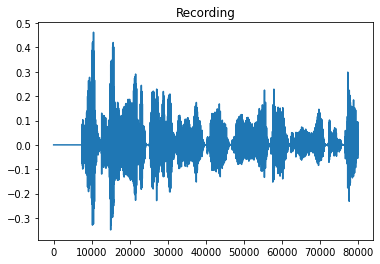

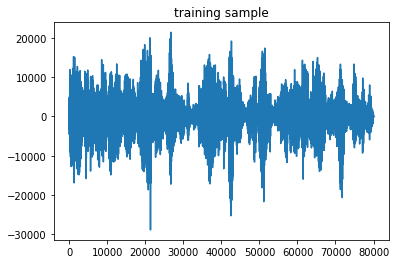

In [9]:
import matplotlib.pyplot as plt
plt.plot(myrecording)
plt.title("Recording")
plt.show()
plt.plot(clip)
plt.title("training sample")
plt.show()

As we can see the two audio don't have the same amplitude, but I think normalization step will solve this problem

In [10]:
assert clip.shape == myrecording.shape, "The recorded audio doesn't have the same shape as the training clip" 

In [11]:
_, _, fft_rec = scipy.signal.spectrogram(myrecording,
                                        fs = sample_rate,
                                        nperseg = FFT_N_PERSEG,
                                        noverlap = FFT_N_OVERLAP,
                                        window = FFT_WINDOW_TYPE
                                        )
# print("fft output shape :", fft_rec.shape)
fft_rec = fft_rec / (np.linalg.norm(fft_rec, axis=0, keepdims=True) + EPS)
fft_rec = fft_rec.astype(np.float32)
fft_rec = fft_rec[None, :, :] # Add the batch dimension = 1
fft_rec.shape

(1, 201, 498)

In [12]:
fft_rec_old = np.abs(librosa.stft(myrecording, n_fft=400, hop_length=160)).T
fft_rec_old = fft_rec_old[:500, :]
fft_rec_old = fft_rec_old / (np.linalg.norm(fft_rec_old, axis=0, keepdims=True) + EPS)
fft_rec_old = fft_rec_old.astype(np.float32)
fft_rec_old = fft_rec_old[None, :, :] # Add the batch dimension = 1
fft_rec_old.shape

(1, 500, 201)

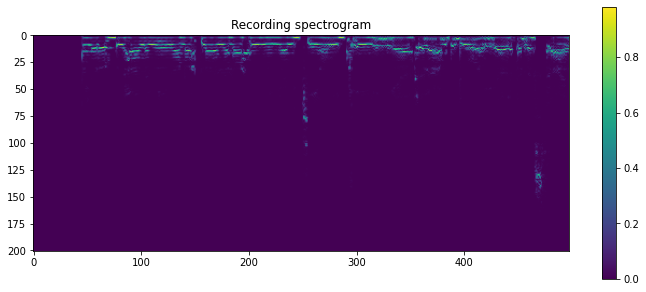

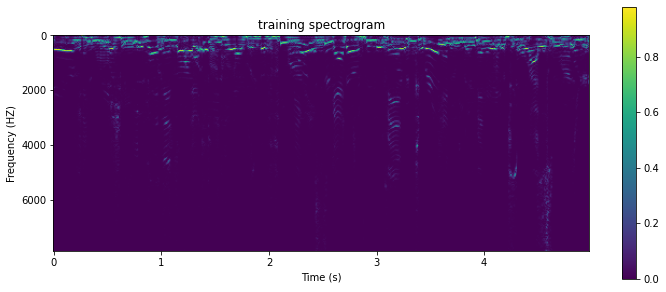

In [38]:
plt.figure(figsize=(12, 5))
plt.imshow(fft_rec[0,:,:])
plt.colorbar()
plt.title("Recording spectrogram")

plt.figure(figsize=(12, 5))
plt.imshow(fft[0,:,:])
plt.colorbar()
plt.title("training spectrogram")

plt.yticks(np.arange(0, fft_rec.shape[1], step=51), np.arange(0, 8000, step=2000))
plt.ylabel("Frequency (HZ)")
plt.xticks(np.arange(0, fft.shape[2], step=100), np.arange(0, 5, step=1))
plt.xlabel("Time (s)")
plt.savefig("../assets/stft.png", dpi=300)
plt.show()

The expected, the normalization renders the spectrogram to the same scale

In [122]:
fft_rec.shape

(1, 201, 498)

In [123]:
fft_rec_old.shape

(1, 500, 201)

Text(0.5, 1.0, 'Old rec spectrogram')

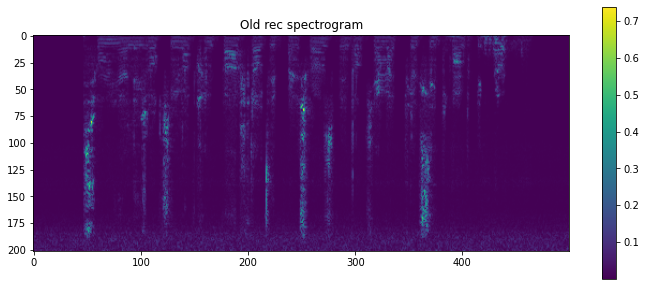

In [124]:
plt.figure(figsize=(12, 5))
plt.imshow(fft_rec_old[0,:,:].T)
plt.colorbar()
plt.title("Old rec spectrogram")

In [125]:
ort_sess = ort.InferenceSession('onnx/f-crnn.onnx')
# ort_sess = ort.InferenceSession('../old_model_conversion/onnx/CRNN_ONNX.onnx')

tik = time()
outputs = ort_sess.run([], {'x': fft_rec})
# outputs = ort_sess.run([], {'zero1_input': fft_rec_old[None, :, :, :]})
tok = time()
print("Activations [M, F] :", outputs[0][0])
# print("Activations :", outputs[0][0])
print("Total amount of people :", round(outputs[0][0].sum()))
# print("Total amount of people :", np.argmax(outputs[0][0]))
print("Duration :{:.3f}s".format(tok-tik))

Activations [M, F] : [0.65540314 1.3023336 ]
Total amount of people : 2
Duration :0.002s


In [126]:
ort_sess = ort.InferenceSession('../old_model_conversion/onnx/CRNN_ONNX.onnx')

tik = time()
# outputs = ort_sess.run([], {'x': fft_rec})
outputs = ort_sess.run([], {'zero1_input': fft_rec_old[None, :, :, :]})
tok = time()
# print("Activations [M, F] :", outputs[0][0])
print("Activations :", outputs[0][0])
# print("Total amount of people :", round(outputs[0][0].sum()))
print("Total amount of people :", np.argmax(outputs[0][0]))
print("Duration :{:.3f}s".format(tok-tik))

Activations : [2.6680567e-04 8.8184714e-01 1.1784285e-01 4.3231921e-05 3.1460918e-09
 1.4946015e-10 9.8934532e-12 3.5240552e-12 3.7395213e-12 1.8957949e-12
 1.2774972e-12]
Total amount of people : 1
Duration :0.041s


### Saliency maps

In [127]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

model = tf.keras.models.load_model('saved/tf_model/')

TensorFlow version: 2.7.0
1 Physical GPUs, 1 Logical GPUs


In [82]:
inp = tf.convert_to_tensor(
    fft_rec,
    dtype = tf.float32
)
inp_var = tf.Variable(inp)

In [83]:
model(inp_var).numpy()

array([[-0.04679659,  1.1228293 ]], dtype=float32)

In [84]:
# ---------------------------------------------------------------------------- #
#                                     Male                                     #
# ---------------------------------------------------------------------------- #
with tf.GradientTape() as tape:
    pred = model(inp_var, training=False)
    # class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    # print("Top 5 predictions:", class_idxs_sorted[:5]) => Top 5 predictions: [1 0]
    # loss = pred[0][class_idxs_sorted[0]]
    loss_male = pred[0][0]
# grads = tape.gradient(loss, inp_var)
grads_male = tape.gradient(loss_male, inp_var)
# ---------------------------------------------------------------------------- #
#                                    Female                                    #
# ---------------------------------------------------------------------------- #
with tf.GradientTape() as tape:
    pred = model(inp_var, training=False)
    loss_female = pred[0][1]
grads_female = tape.gradient(loss_female, inp_var)

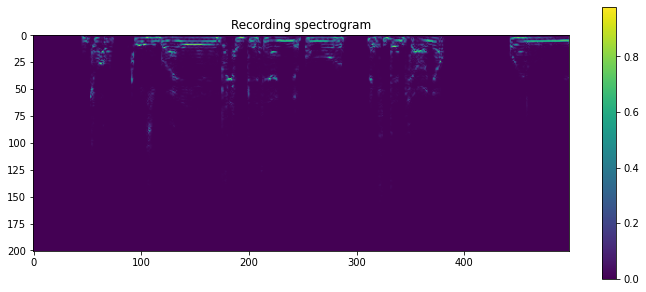

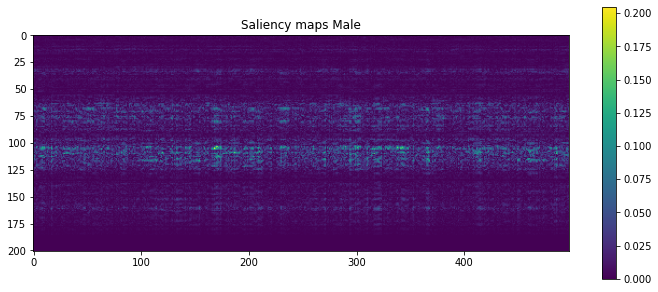

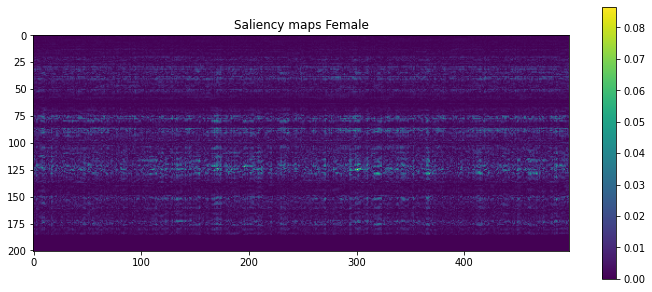

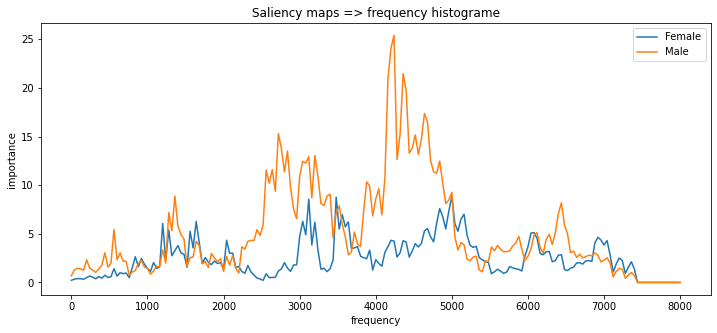

In [95]:
# grads.numpy().shape
plt.figure(figsize=(12, 5))
plt.imshow(fft_rec[0,:,:])
plt.colorbar()
plt.title("Recording spectrogram")

plt.figure(figsize=(12, 5))
plt.imshow(np.abs(grads_male.numpy()[0,:,:]))
plt.colorbar()
plt.title("Saliency maps Male")

plt.figure(figsize=(12, 5))
plt.imshow(np.abs(grads_female.numpy()[0,:,:]))
plt.colorbar()
plt.title("Saliency maps Female")


plt.figure(figsize=(12, 5))
plt.plot([40*i for i in range(201)],np.abs(grads_female.numpy()[0,:,:]).sum(axis=1), label="Female")
plt.plot([40*i for i in range(201)],np.abs(grads_male.numpy()[0,:,:]).sum(axis=1), label="Male")
plt.ylabel("importance")
plt.xlabel("frequency")
plt.legend()
# plt.colorbar()
plt.title("Saliency maps => frequency histograme")
plt.show()

database audio

In [96]:
inp = tf.convert_to_tensor(
    fft,
    dtype = tf.float32
)
inp_var = tf.Variable(inp)

In [97]:
model(inp_var).numpy()

array([[3.2492676, 2.632199 ]], dtype=float32)

In [98]:
# ---------------------------------------------------------------------------- #
#                                     Male                                     #
# ---------------------------------------------------------------------------- #
with tf.GradientTape() as tape:
    pred = model(inp_var, training=False)
    # class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    # print("Top 5 predictions:", class_idxs_sorted[:5]) => Top 5 predictions: [1 0]
    # loss = pred[0][class_idxs_sorted[0]]
    loss_male = pred[0][0]
# grads = tape.gradient(loss, inp_var)
grads_male = tape.gradient(loss_male, inp_var)
# ---------------------------------------------------------------------------- #
#                                    Female                                    #
# ---------------------------------------------------------------------------- #
with tf.GradientTape() as tape:
    pred = model(inp_var, training=False)
    loss_female = pred[0][1]
grads_female = tape.gradient(loss_female, inp_var)

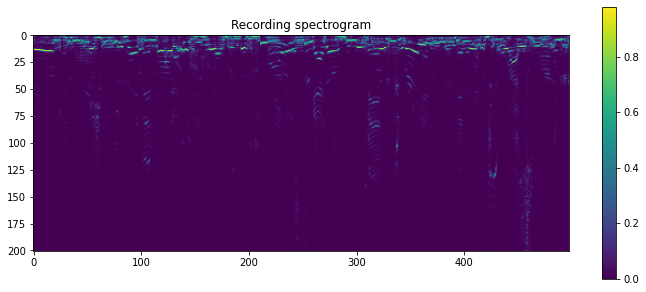

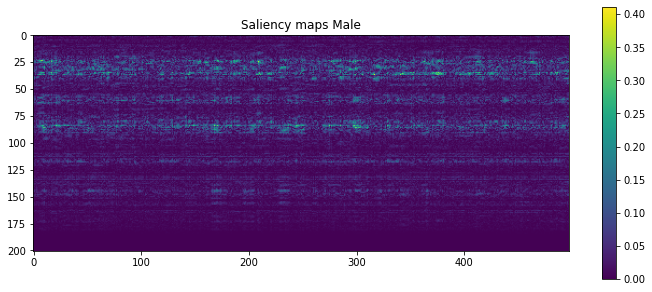

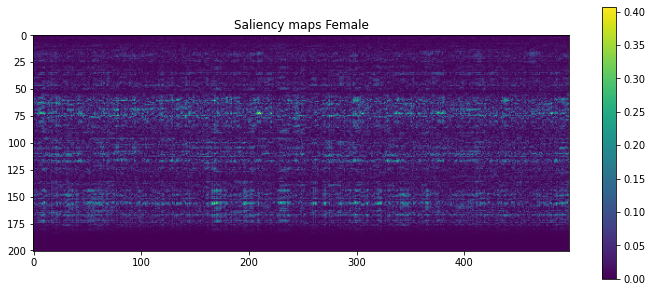

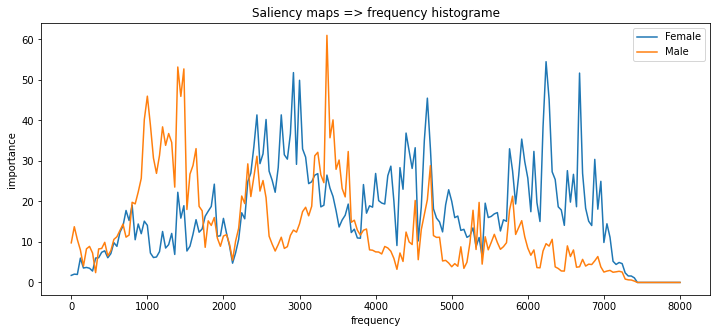

In [100]:
# grads.numpy().shape
plt.figure(figsize=(12, 5))
plt.imshow(fft[0,:,:])
plt.colorbar()
plt.title("dataset spectrogram")

plt.figure(figsize=(12, 5))
plt.imshow(np.abs(grads_male.numpy()[0,:,:]))
plt.colorbar()
plt.title("Saliency maps Male")

plt.figure(figsize=(12, 5))
plt.imshow(np.abs(grads_female.numpy()[0,:,:]))
plt.colorbar()
plt.title("Saliency maps Female")

plt.figure(figsize=(12, 5))
plt.plot([40*i for i in range(201)],np.abs(grads_female.numpy()[0,:,:]).sum(axis=1), label="Female")
plt.plot([40*i for i in range(201)],np.abs(grads_male.numpy()[0,:,:]).sum(axis=1), label="Male")
plt.ylabel("importance")
plt.xlabel("frequency")
plt.legend()
# plt.colorbar()
plt.title("Saliency maps => frequency histograme")
plt.show()
